In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

## Importation des données

In [2]:
df_train = pd.read_csv("data/train.csv")
df_train.head()

,S.No,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,...,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,time,LABELS
0,0,-24.758801,242.1875,16.019615,-4.391696,4.777769,-6.388222,7.725320,0.010277,102326.2344,...,221.594223,261.823212,6.660000e-09,295.622253,293.301514,197.698624,12234.78809,64.372635,20030804,0
1,1,23.820078,277.8125,47.802036,8.623652,9.308566,4.596105,9.938286,0.018531,100803.1094,...,220.343719,269.106720,3.670000e-16,302.496826,302.654083,71.571518,12463.97266,66.834389,20071006,1
2,2,23.820078,276.8750,11.556691,-2.483993,-6.009627,-3.503036,-5.921963,0.007468,101885.3906,...,215.933487,259.610718,0.000000e+00,299.854919,293.339996,160.414246,12099.36133,64.209663,20020331,0
3,3,13.494133,253.1250,53.186630,0.150933,-1.319407,3.757741,-2.172120,0.018809,100824.6328,...,218.457672,267.374329,9.800000e-08,301.606934,299.973450,72.840614,12379.26855,66.243294,20000906,0
4,4,-24.524120,241.2500,23.353998,-7.467506,-5.113565,-9.545109,-4.691221,0.011672,102553.8984,...,214.316605,263.575409,6.410000e-09,295.819488,295.101257,218.449570,12261.22656,64.876427,20000906,0


In [3]:
df_train.shape

(47760, 21)

In [4]:
# On s'assure qu'il n'y a pas de valeurs non numériques ou manquantes dans le dataframe
df_train.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

# On peut le faire plus simplement par cette commande
# df_train.isna().sum()

S.No      True
lat       True
lon       True
TMQ       True
U850      True
V850      True
UBOT      True
VBOT      True
QREFHT    True
PS        True
PSL       True
T200      True
T500      True
PRECT     True
TS        True
TREFHT    True
Z1000     True
Z200      True
ZBOT      True
time      True
LABELS    True
dtype: bool

In [5]:
# On remarque que les données sont imbalancées
df_train.value_counts("LABELS")

LABELS
0    37535
2     8223
1     2002
dtype: int64

In [6]:
# On choisis les colonnes à enlever pour les training inputs
X_columns = [c for c in df_train.columns if c not in ['S.No', 'LABELS']]
# X_columns = [c for c in df_train.columns if c not in ['lat', 'lon','time', 'S.No', 'LABELS']]

# On peut prendre un sous-ensemble des données ici en prenant un sous-ensembles de lignes
df_train_sorted = df_train.sort_values(by=['LABELS'], axis=0, ascending=False)
df_train_final = df_train_sorted.iloc[:, :]

In [7]:
# On sépare les inputs et les labels
# Note: on a pas besoin de normaliser les données avec XGBoost
X = df_train_final.loc[:, X_columns]
y = df_train_final.loc[:, 'LABELS']

# 20% des données vont être sélectionner aléatoirement pour la validation et le reste pour l'entraînement (Shuffled)
# Ces données sont prêts à être traités par n'importe quels algorithmes
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((38208, 19), (9552, 19), (38208,), (9552,))

In [24]:
# X_mean = (X - X.mean())/X.std()
# X_mean

,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,time
26746,-1.219160,2.050515,-0.532517,0.481683,1.058099,1.020219,-0.302803,-1.105212,1.558231,1.556911,-1.555070,-1.525661,-0.193868,-1.943712,-1.579934,1.577076,-1.419093,-1.466333,1.828370
7232,-0.778623,-0.949125,0.093632,-0.819466,0.913784,-1.335107,2.422006,-0.807125,0.795105,0.792373,0.060443,0.387881,-0.130765,-0.097080,-0.500831,0.816403,0.339932,-0.673669,-0.904959
30228,-1.229405,2.050515,0.319368,0.806170,0.583679,1.597317,-0.089273,-0.329196,0.424348,0.420930,-0.769941,-0.130786,-0.193001,-0.695253,-0.331200,0.437074,0.117517,-0.292664,-0.620773
7222,-1.198669,2.042902,-1.244397,1.285565,-0.619138,1.188218,-0.860827,-1.337503,0.822112,0.819430,1.043303,-0.321962,-0.146274,-1.905603,-1.574683,0.791630,-0.535437,-1.510236,-1.173375
22343,-0.768378,-0.964351,0.618151,0.977241,-2.131053,0.621883,-1.610250,0.660658,-0.568045,-0.573299,0.250575,0.578344,0.086357,0.144960,0.264340,-0.627391,0.277241,0.331582,-0.088040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17805,0.696663,-0.408580,0.329476,-0.519810,-1.615545,0.035846,-0.363522,0.624414,-1.084715,-1.090925,0.515497,0.691709,-0.194058,0.790154,0.724973,-1.192614,0.798994,0.735004,-0.364191
17806,-0.963034,-0.675046,-0.461363,-0.751572,-0.065424,-1.317744,1.575583,-0.835523,1.527603,1.526226,0.157480,-0.672743,-0.194057,-0.800966,-0.839189,1.589191,-0.515305,-0.886482,2.106817
17808,-0.788868,-0.979578,0.220360,-0.880165,-0.963077,-0.857883,-0.338065,0.047229,0.460958,0.457608,-0.733111,0.071604,-0.139567,-0.222580,-0.018284,0.494770,-0.035732,0.009240,-1.727727
17809,1.075729,0.170030,-0.278527,1.180756,-0.211149,1.083349,-1.168988,-0.567040,-0.370794,-0.373519,-0.520693,-0.524761,-0.194058,0.382825,0.011742,-0.425794,-0.749356,-0.129448,-0.642720


## Optimisation des hyper-paramètres
#### (Prend beaucoup de temps)

In [6]:
# param_grid = {
#     'n_estimators':[4000, 50006000, ],
#     'max_depth':[4,5,6]
# }

In [9]:
# optimal_model = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
#                                                      seed=3395,
#                                                      min_child_weight=1,
#                                                      gamma=0,
#                                                      lamda=1,
#                                                      subsample=0.5,
#                                                      colsample_bytree=0.5,
#                                                      scale_pos_weight = 1,
#                                                      objective='multi:softmax',
#                                                      num_class=3,
#                                                      nthread=8,
#                                                      verbosity=1),
#                               param_grid=param_grid,
#                               scoring='roc_auc',
#                               verbose=2,
#                               n_jobs=8,
#                               cv=5
# )

# optimal_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)], verbose=True)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:45:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "lamda", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:45:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.01268
[1]	validation_0-mlogloss:0.93905
[2]	validation_0-mlogloss:0.87636
[3]	validation_0-mlogloss:0.82196
[4]	validation_0-mlogloss:0.77508
[5]	validation_0-mlogloss:0.73463
[6]	validation_0-mlogloss:0.69895
[7]	validation_0-

[210]	validation_0-mlogloss:0.26665
[211]	validation_0-mlogloss:0.26627
[212]	validation_0-mlogloss:0.26616
[213]	validation_0-mlogloss:0.26586
[214]	validation_0-mlogloss:0.26560
[215]	validation_0-mlogloss:0.26547
[216]	validation_0-mlogloss:0.26522
[217]	validation_0-mlogloss:0.26497
[218]	validation_0-mlogloss:0.26484
[219]	validation_0-mlogloss:0.26476
[220]	validation_0-mlogloss:0.26449
[221]	validation_0-mlogloss:0.26434
[222]	validation_0-mlogloss:0.26422
[223]	validation_0-mlogloss:0.26416
[224]	validation_0-mlogloss:0.26391
[225]	validation_0-mlogloss:0.26367
[226]	validation_0-mlogloss:0.26343
[227]	validation_0-mlogloss:0.26336
[228]	validation_0-mlogloss:0.26312
[229]	validation_0-mlogloss:0.26306
[230]	validation_0-mlogloss:0.26294
[231]	validation_0-mlogloss:0.26277
[232]	validation_0-mlogloss:0.26259
[233]	validation_0-mlogloss:0.26247
[234]	validation_0-mlogloss:0.26226
[235]	validation_0-mlogloss:0.26206
[236]	validation_0-mlogloss:0.26184
[237]	validation_0-mlogloss:

[438]	validation_0-mlogloss:0.24595
[439]	validation_0-mlogloss:0.24587
[440]	validation_0-mlogloss:0.24583
[441]	validation_0-mlogloss:0.24585
[442]	validation_0-mlogloss:0.24580
[443]	validation_0-mlogloss:0.24589
[444]	validation_0-mlogloss:0.24579
[445]	validation_0-mlogloss:0.24594
[446]	validation_0-mlogloss:0.24580
[447]	validation_0-mlogloss:0.24571
[448]	validation_0-mlogloss:0.24568
[449]	validation_0-mlogloss:0.24561
[450]	validation_0-mlogloss:0.24556
[451]	validation_0-mlogloss:0.24557
[452]	validation_0-mlogloss:0.24551
[453]	validation_0-mlogloss:0.24543
[454]	validation_0-mlogloss:0.24539
[455]	validation_0-mlogloss:0.24537
[456]	validation_0-mlogloss:0.24531
[457]	validation_0-mlogloss:0.24519
[458]	validation_0-mlogloss:0.24508
[459]	validation_0-mlogloss:0.24509
[460]	validation_0-mlogloss:0.24510
[461]	validation_0-mlogloss:0.24497
[462]	validation_0-mlogloss:0.24498
[463]	validation_0-mlogloss:0.24492
[464]	validation_0-mlogloss:0.24492
[465]	validation_0-mlogloss:

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None, lamda=1,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=5000, n_jobs=None, nthread=8,
                                     num_class=3, num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None,
                                     random_state=No

### Résultats pour les différents hyper-paramètres

## Modèle avec les paramètres ajustés

In [12]:
optimal_model = XGBClassifier(learning_rate=0.1,
                                      seed=3395,
                                      max_depth=5,
                                      n_estimators=5000,
                                      min_child_weight=1,
                                      gamma=0,
                                      lamda=100,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      scale_pos_weight = 1,
                                      objective='multi:softmax',
                                      num_class=3,
                                      nthread=8,
                                      verbosity=1)

optimal_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)], verbose=True)

[23:47:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "lamda", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:47:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.00950
[1]	validation_0-mlogloss:0.93337
[2]	validation_0-mlogloss:0.86867
[3]	validation_0-mlogloss:0.81244


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:0.76381
[5]	validation_0-mlogloss:0.72180
[6]	validation_0-mlogloss:0.68474
[7]	validation_0-mlogloss:0.65099
[8]	validation_0-mlogloss:0.62116
[9]	validation_0-mlogloss:0.59458
[10]	validation_0-mlogloss:0.57209
[11]	validation_0-mlogloss:0.55123
[12]	validation_0-mlogloss:0.53173
[13]	validation_0-mlogloss:0.51402
[14]	validation_0-mlogloss:0.49812
[15]	validation_0-mlogloss:0.48422
[16]	validation_0-mlogloss:0.47144
[17]	validation_0-mlogloss:0.45959
[18]	validation_0-mlogloss:0.44874
[19]	validation_0-mlogloss:0.43872
[20]	validation_0-mlogloss:0.42990
[21]	validation_0-mlogloss:0.42160
[22]	validation_0-mlogloss:0.41386
[23]	validation_0-mlogloss:0.40685
[24]	validation_0-mlogloss:0.40017
[25]	validation_0-mlogloss:0.39356
[26]	validation_0-mlogloss:0.38803
[27]	validation_0-mlogloss:0.38174
[28]	validation_0-mlogloss:0.37705
[29]	validation_0-mlogloss:0.37201
[30]	validation_0-mlogloss:0.36774
[31]	validation_0-mlogloss:0.36365
[32]	validation_0-mlogloss

[235]	validation_0-mlogloss:0.24436
[236]	validation_0-mlogloss:0.24434
[237]	validation_0-mlogloss:0.24440
[238]	validation_0-mlogloss:0.24424
[239]	validation_0-mlogloss:0.24426
[240]	validation_0-mlogloss:0.24435
[241]	validation_0-mlogloss:0.24437
[242]	validation_0-mlogloss:0.24443
[243]	validation_0-mlogloss:0.24419
[244]	validation_0-mlogloss:0.24417
[245]	validation_0-mlogloss:0.24416
[246]	validation_0-mlogloss:0.24404
[247]	validation_0-mlogloss:0.24395
[248]	validation_0-mlogloss:0.24389
[249]	validation_0-mlogloss:0.24388
[250]	validation_0-mlogloss:0.24391
[251]	validation_0-mlogloss:0.24366
[252]	validation_0-mlogloss:0.24354
[253]	validation_0-mlogloss:0.24331
[254]	validation_0-mlogloss:0.24334
[255]	validation_0-mlogloss:0.24329
[256]	validation_0-mlogloss:0.24335
[257]	validation_0-mlogloss:0.24311
[258]	validation_0-mlogloss:0.24295
[259]	validation_0-mlogloss:0.24288
[260]	validation_0-mlogloss:0.24286
[261]	validation_0-mlogloss:0.24283
[262]	validation_0-mlogloss:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='', lamda=100,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=8, nthread=8, num_class=3,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=3395, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=3395, subsample=0.5, ...)

# Résultats
### Aire sous la courbe

Text(0, 0.5, 'Feature Importance Score')

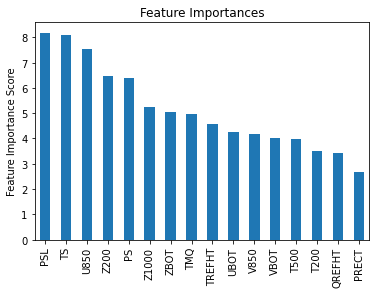

In [13]:
feat_imp = pd.Series(optimal_model.get_booster().get_score(importance_type="gain")).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      7532
           1       0.73      0.69      0.71       373
           2       0.74      0.63      0.68      1647

    accuracy                           0.88      9552
   macro avg       0.79      0.76      0.77      9552
weighted avg       0.88      0.88      0.88      9552



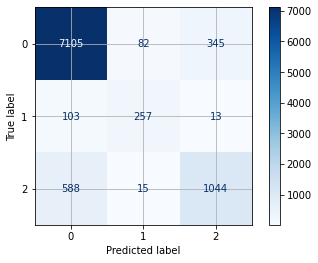

In [14]:
# Area under the curve
report_with_auc = classification_report(y_valid, optimal_model.predict(X_valid))
print(report_with_auc)
plot_confusion_matrix(optimal_model, X_valid, y_valid, cmap='Blues', display_labels=['0', '1', '2'])
plt.grid(None);

### Matrice de confusion pour l'entraînement

In [15]:
y_train_pred = optimal_model.predict(X_train)
confmat = confusion_matrix(y_train, y_train_pred)
sum_preds = np.sum(confmat)
sum_correct = np.sum(np.diag(confmat))
print(confmat)
print("The training error is ", round(100 * (1.0 - (float(sum_correct) / float(sum_preds))), 2), "%")
print("Then, the training accuracy is ", round(100 * (float(sum_correct) / float(sum_preds)), 2), "%")

[[28881   229   893]
 [  312  1287    30]
 [ 1902    44  4630]]
The training error is  8.92 %
Then, the training accuracy is  91.08 %


### Matrice de confusion pour la validation

In [16]:
# Matrice
y_valid_pred = optimal_model.predict(X_valid)
confmat = confusion_matrix(y_valid, y_valid_pred)
sum_preds = np.sum(confmat)
sum_correct = np.sum(np.diag(confmat))
print(confmat)
print("The validation error is ", round(100 * (1.0 - (float(sum_correct) / float(sum_preds))), 2), "%")
print("Then, the validation accuracy is ", round(100 * (float(sum_correct) / float(sum_preds)), 2), "%")

[[7105   82  345]
 [ 103  257   13]
 [ 588   15 1044]]
The validation error is  12.0 %
Then, the validation accuracy is  88.0 %


## On applique le model sur les données de test
#### On obtient le fichier 'submission.csv'

In [17]:
# Real test
df_test = pd.read_csv('test.csv')
X_test = df_test.loc[:, X_columns]

In [18]:
X_test_pred = optimal_model.predict(X_test)
np.unique(X_test_pred, return_counts=True)

(array([0, 1, 2], dtype=int64), array([6321,  177,  822], dtype=int64))

In [19]:
df = pd.read_csv('submission.csv')
df.loc[:, 'LABELS'] = X_test_pred
df.to_csv('submission.csv', index=False)

### Comparaison avec d'autres soumissions

In [20]:
# Obtenu avec les mêmes paramètres de modèles, mais sans retirer lat, lon et time
df2 = pd.read_csv('submission_best.csv')
np.unique(df2.iloc[:, 1], return_counts=True)

(array([0, 1, 2], dtype=int64), array([6170,  432,  718], dtype=int64))

In [21]:
df3 = pd.read_csv('submission_gab2.csv')
np.unique(df3.iloc[:, 1], return_counts=True)

(array([0, 1, 2], dtype=int64), array([6037,  322,  961], dtype=int64))